<a href="https://colab.research.google.com/github/alxfed/time-to-test-new-tensorflow/blob/master/Regression_with_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Generated-Datasets" data-toc-modified-id="Generated-Datasets-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Generated Datasets</a></span></li><li><span><a href="#Boston-Dataset" data-toc-modified-id="Boston-Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Boston Dataset</a></span></li><li><span><a href="#Simple-Multi-Regression" data-toc-modified-id="Simple-Multi-Regression-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Simple Multi Regression</a></span></li><li><span><a href="#Regularization" data-toc-modified-id="Regularization-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Regularization</a></span><ul class="toc-item"><li><span><a href="#Lasso-Regularlization" data-toc-modified-id="Lasso-Regularlization-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Lasso Regularlization</a></span></li><li><span><a href="#Ridge-Regularization" data-toc-modified-id="Ridge-Regularization-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Ridge Regularization</a></span></li><li><span><a href="#ElasticNet-Regularization" data-toc-modified-id="ElasticNet-Regularization-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>ElasticNet Regularization</a></span></li></ul></li></ul></div>

# Regression with TensorFlow <a class="tocSkip">

In [1]:
import tensorflow as tf
print('TensorFlow:{}'.format(tf.__version__))
tf.set_random_seed(123)

import numpy as np
print('NumPy:{}'.format(np.__version__))
np.random.seed(123)

import matplotlib.pyplot as plt

import sklearn as sk
print('Scikit Learn:{}'.format(sk.__version__))
from sklearn import model_selection as skms
from sklearn import datasets as skds
from sklearn import preprocessing as skpp

TensorFlow:1.13.0-rc1
NumPy:1.14.6
Scikit Learn:0.20.2


# Generated Datasets

In [0]:
X, y = skds.make_regression(
    n_samples=200, n_features=1, n_informative=1, n_targets=1, noise=20.0)
if (y.ndim == 1):
    y = y.reshape(-1, 1)

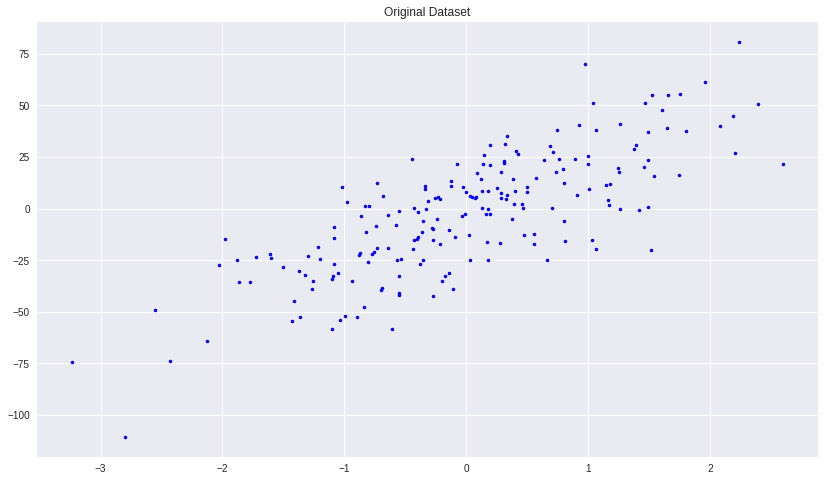

In [3]:
plt.figure(figsize=(14,8))
plt.plot(X,y,'b.')
plt.title('Original Dataset')
plt.show()

In [0]:
X_train, X_test, y_train, y_test = skms.train_test_split(
    X, y, test_size=.4, random_state=123)

In [5]:
num_outputs = y_train.shape[1]
num_inputs = X_train.shape[1]

x_tensor = tf.placeholder(dtype=tf.float32, shape=[None, num_inputs], name='x')
y_tensor = tf.placeholder(
    dtype=tf.float32, shape=[None, num_outputs], name='y')

w = tf.Variable(
    tf.zeros([num_inputs, num_outputs]), dtype=tf.float32, name='w')
b = tf.Variable(tf.zeros([num_outputs]), dtype=tf.float32, name='b')

model = tf.matmul(x_tensor, w) + b

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
loss = tf.reduce_mean(tf.square(model - y_tensor))
mse = tf.reduce_mean(tf.square(model - y_tensor))
y_mean = tf.reduce_mean(y_tensor)
total_error = tf.reduce_sum(tf.square(y_tensor - y_mean))
unexplained_error = tf.reduce_sum(tf.square(y_tensor - model))
rs = 1 - tf.div(unexplained_error, total_error)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [0]:
learning_rate = 0.001
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [8]:
num_epochs = 1500
w_hat = 0
b_hat = 0
loss_epochs = np.empty(shape=[num_epochs], dtype=np.float32)
mse_epochs = np.empty(shape=[num_epochs], dtype=np.float32)
rs_epochs = np.empty(shape=[num_epochs], dtype=np.float32)

mse_score = 0
rs_score = 0

with tf.Session() as tfs:
    tfs.run(tf.global_variables_initializer())
    for epoch in range(num_epochs):
        feed_dict = {x_tensor: X_train, y_tensor: y_train}
        loss_val, _ = tfs.run([loss, optimizer], feed_dict=feed_dict)
        loss_epochs[epoch] = loss_val

        feed_dict = {x_tensor: X_test, y_tensor: y_test}
        mse_score, rs_score = tfs.run([mse, rs], feed_dict=feed_dict)
        mse_epochs[epoch] = mse_score
        rs_epochs[epoch] = rs_score

    w_hat, b_hat = tfs.run([w, b])
    w_hat = w_hat.reshape(1)

print('model : Y = {0:.8f} X + {1:.8f}'.format(w_hat[0], b_hat[0]))
print('For test data : MSE = {0:.8f}, R2 = {1:.8f} '.format(
    mse_score, rs_score))

model : Y = 20.37448120 X + -2.75295663
For test data : MSE = 297.57992554, R2 = 0.66098368 


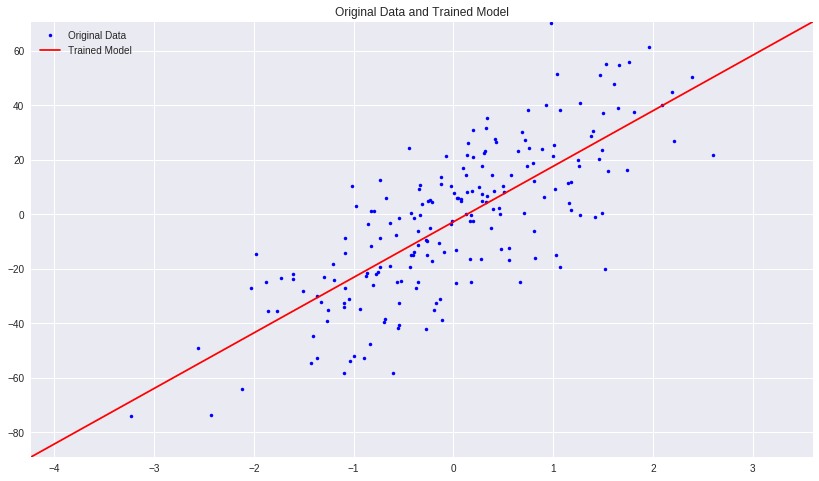

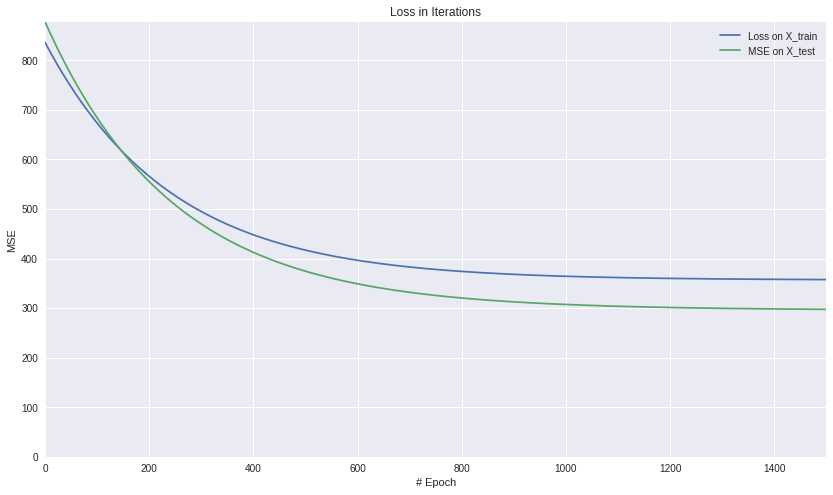

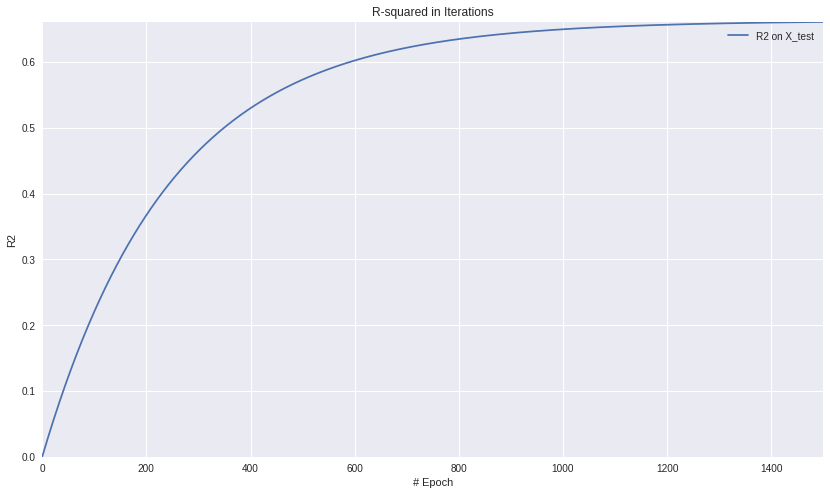

In [9]:
plt.figure(figsize=(14, 8))
plt.title('Original Data and Trained Model')

x_plot = [np.min(X) - 1, np.max(X) + 1]
y_plot = w_hat * x_plot + b_hat
plt.axis([x_plot[0], x_plot[1], y_plot[0], y_plot[1]])
plt.plot(X, y, 'b.', label='Original Data')
plt.plot(x_plot, y_plot, 'r-', label='Trained Model')
plt.legend()
plt.show()

plt.figure(figsize=(14, 8))

plt.axis([0, num_epochs, 0, np.max(loss_epochs)])
plt.plot(loss_epochs, label='Loss on X_train')
plt.title('Loss in Iterations')
plt.xlabel('# Epoch')
plt.ylabel('MSE')

plt.axis([0, num_epochs, 0, np.max(mse_epochs)])
plt.plot(mse_epochs, label='MSE on X_test')
plt.xlabel('# Epoch')
plt.ylabel('MSE')
plt.legend()

plt.show()

plt.figure(figsize=(14, 8))

plt.axis([0, num_epochs, np.min(rs_epochs), np.max(rs_epochs)])
plt.title('R-squared in Iterations')
plt.plot(rs_epochs, label='R2 on X_test')
plt.xlabel('# Epoch')
plt.ylabel('R2')
plt.legend()

plt.show()

# Boston Dataset

In [10]:
boston=skds.load_boston()
print(boston.DESCR)

X=boston.data.astype(np.float32)
y=boston.target.astype(np.float32)
if (y.ndim == 1):
    y = y.reshape(-1,1)
X = skpp.StandardScaler().fit_transform(X)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [11]:
X_train, X_test, y_train, y_test = skms.train_test_split(
    X, y, test_size=.4, random_state=123)
print(X_train.shape)

(303, 13)


# Simple Multi Regression

In [0]:
num_outputs = y_train.shape[1]
num_inputs = X_train.shape[1]

x_tensor = tf.placeholder(dtype=tf.float32, shape=[None, num_inputs], name='x')
y_tensor = tf.placeholder(
    dtype=tf.float32, shape=[None, num_outputs], name='y')

w = tf.Variable(
    tf.zeros([num_inputs, num_outputs]), dtype=tf.float32, name='w')
b = tf.Variable(tf.zeros([num_outputs]), dtype=tf.float32, name='b')

model = tf.matmul(x_tensor, w) + b

In [0]:
loss = tf.reduce_mean(tf.square(model - y_tensor))
mse = tf.reduce_mean(tf.square(model - y_tensor))
y_mean = tf.reduce_mean(y_tensor)
total_error = tf.reduce_sum(tf.square(y_tensor - y_mean))
unexplained_error = tf.reduce_sum(tf.square(y_tensor - model))
rs = 1 - tf.div(unexplained_error, total_error)

In [0]:
learning_rate = 0.001
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [15]:
num_epochs = 1500
loss_epochs = np.empty(shape=[num_epochs], dtype=np.float32)
mse_epochs = np.empty(shape=[num_epochs], dtype=np.float32)
rs_epochs = np.empty(shape=[num_epochs], dtype=np.float32)

mse_score = 0.0
rs_score = 0.0

with tf.Session() as tfs:
    tfs.run(tf.global_variables_initializer())
    for epoch in range(num_epochs):
        feed_dict = {x_tensor: X_train, y_tensor: y_train}
        loss_val, _ = tfs.run([loss, optimizer], feed_dict)
        loss_epochs[epoch] = loss_val

        feed_dict = {x_tensor: X_test, y_tensor: y_test}
        mse_score, rs_score = tfs.run([mse, rs], feed_dict)
        mse_epochs[epoch] = mse_score
        rs_epochs[epoch] = rs_score

print('For test data : MSE = {0:.8f}, R2 = {1:.8f} '.format(
    mse_score, rs_score))

For test data : MSE = 30.48796844, R2 = 0.64168781 


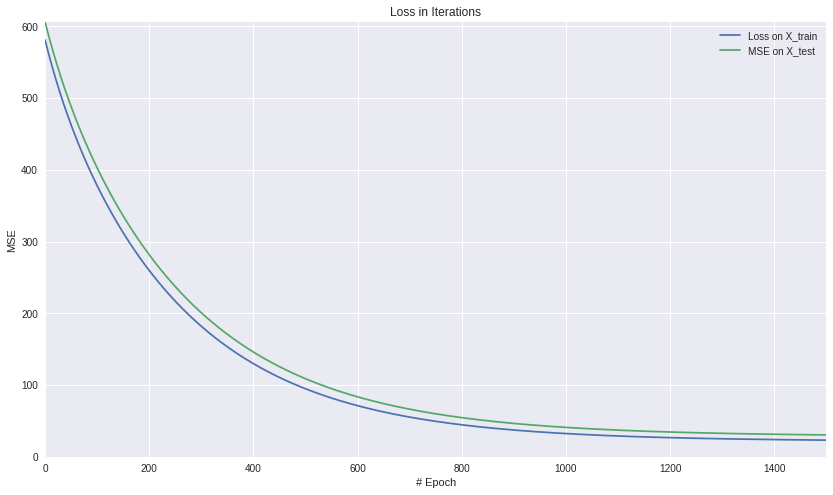

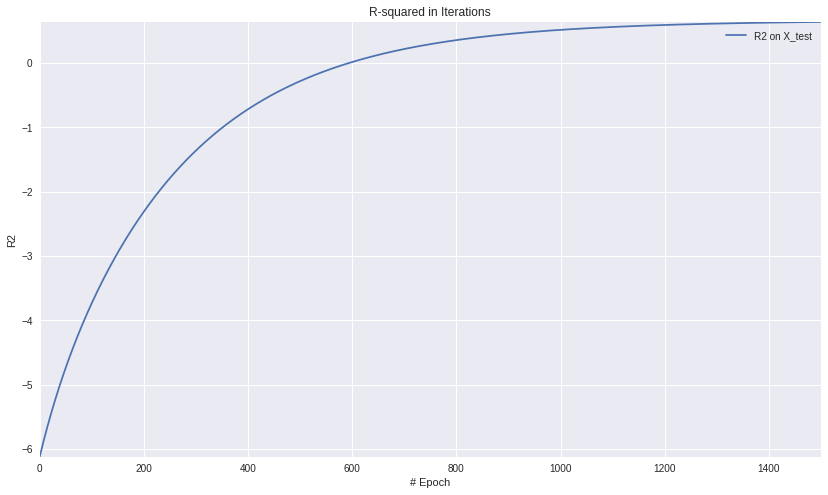

In [16]:
plt.figure(figsize=(14, 8))

plt.axis([0, num_epochs, 0, np.max(loss_epochs)])
plt.plot(loss_epochs, label='Loss on X_train')
plt.title('Loss in Iterations')
plt.xlabel('# Epoch')
plt.ylabel('MSE')

plt.axis([0, num_epochs, 0, np.max(mse_epochs)])
plt.plot(mse_epochs, label='MSE on X_test')
plt.xlabel('# Epoch')
plt.ylabel('MSE')
plt.legend()

plt.show()

plt.figure(figsize=(14, 8))

plt.axis([0, num_epochs, np.min(rs_epochs), np.max(rs_epochs)])
plt.title('R-squared in Iterations')
plt.plot(rs_epochs, label='R2 on X_test')
plt.xlabel('# Epoch')
plt.ylabel('R2')
plt.legend()

plt.show()

# Regularization

## Lasso Regularlization

In [0]:
num_outputs = y_train.shape[1]
num_inputs = X_train.shape[1]

x_tensor = tf.placeholder(dtype=tf.float32,
                          shape=[None, num_inputs], name='x')
y_tensor = tf.placeholder(dtype=tf.float32,
                          shape=[None, num_outputs], name='y')

w = tf.Variable(tf.zeros([num_inputs, num_outputs]),
                dtype=tf.float32, name='w')
b = tf.Variable(tf.zeros([num_outputs]),
                dtype=tf.float32, name='b')

model = tf.matmul(x_tensor, w) + b

lasso_param = tf.Variable(0.8, dtype=tf.float32)
lasso_loss = tf.reduce_mean(tf.abs(w)) * lasso_param

loss = tf.reduce_mean(tf.square(model - y_tensor)) + lasso_loss

learning_rate = 0.001
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

mse = tf.reduce_mean(tf.square(model - y_tensor))
y_mean = tf.reduce_mean(y_tensor)
total_error = tf.reduce_sum(tf.square(y_tensor - y_mean))
unexplained_error = tf.reduce_sum(tf.square(y_tensor - model))
rs = 1 - tf.div(unexplained_error, total_error)

In [18]:
num_epochs = 1500
loss_epochs = np.empty(shape=[num_epochs], dtype=np.float32)
mse_epochs = np.empty(shape=[num_epochs], dtype=np.float32)
rs_epochs = np.empty(shape=[num_epochs], dtype=np.float32)

mse_score = 0.0
rs_score = 0.0

with tf.Session() as tfs:
    tfs.run(tf.global_variables_initializer())
    for epoch in range(num_epochs):
        feed_dict = {x_tensor: X_train, y_tensor: y_train}
        loss_val,_ = tfs.run([loss,optimizer], feed_dict)
        loss_epochs[epoch] = loss_val

        feed_dict = {x_tensor: X_test, y_tensor: y_test}
        mse_score,rs_score = tfs.run([mse,rs], feed_dict)
        mse_epochs[epoch] = mse_score
        rs_epochs[epoch] = rs_score

print('For test data : MSE = {0:.8f}, R2 = {1:.8f} '.format(
    mse_score, rs_score))

For test data : MSE = 30.49273682, R2 = 0.64163178 


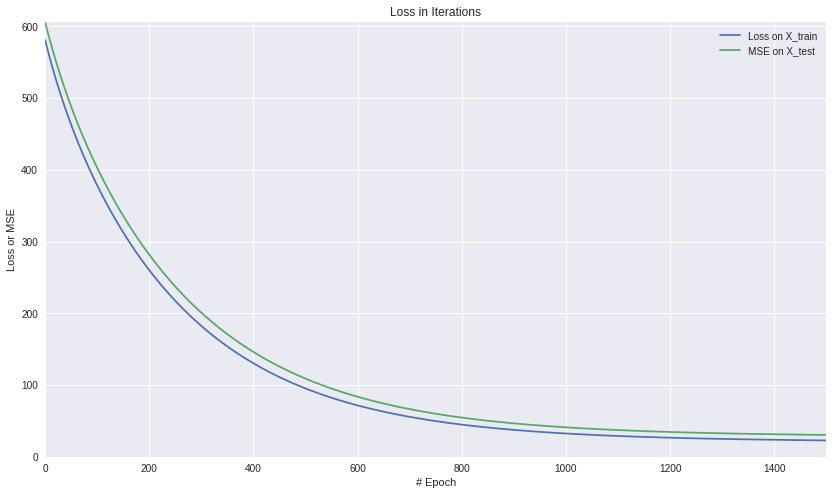

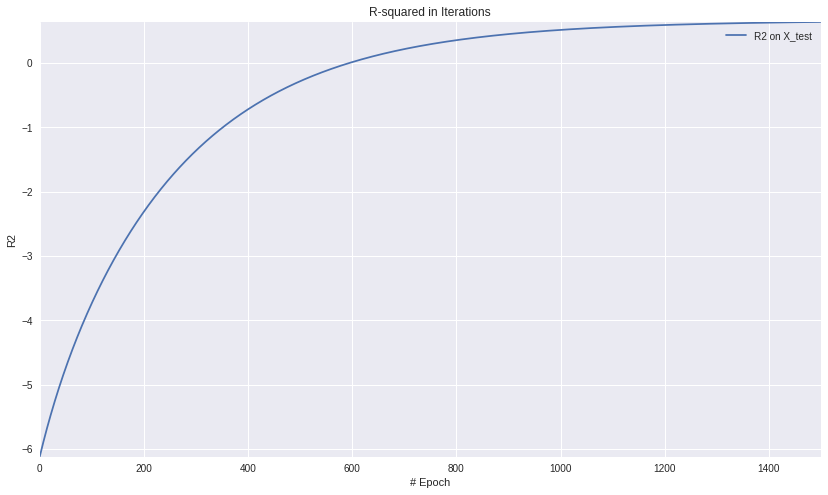

In [19]:
plt.figure(figsize=(14, 8))

plt.axis([0, num_epochs, 0, np.max([loss_epochs, mse_epochs])])
plt.plot(loss_epochs, label='Loss on X_train')
plt.plot(mse_epochs, label='MSE on X_test')
plt.title('Loss in Iterations')
plt.xlabel('# Epoch')
plt.ylabel('Loss or MSE')
plt.legend()

plt.show()

plt.figure(figsize=(14, 8))

plt.axis([0, num_epochs, np.min(rs_epochs), np.max(rs_epochs)])
plt.title('R-squared in Iterations')
plt.plot(rs_epochs, label='R2 on X_test')
plt.xlabel('# Epoch')
plt.ylabel('R2')
plt.legend()

plt.show()

## Ridge Regularization

In [0]:
num_outputs = y_train.shape[1]
num_inputs = X_train.shape[1]

x_tensor = tf.placeholder(dtype=tf.float32,
                          shape=[None, num_inputs], name='x')
y_tensor = tf.placeholder(dtype=tf.float32,
                          shape=[None, num_outputs], name='y')

w = tf.Variable(tf.zeros([num_inputs, num_outputs]),
                dtype=tf.float32, name='w')
b = tf.Variable(tf.zeros([num_outputs]),
                dtype=tf.float32, name='b')

model = tf.matmul(x_tensor, w) + b

ridge_param = tf.Variable(0.8, dtype=tf.float32)
ridge_loss = tf.reduce_mean(tf.square(w)) * ridge_param

loss = tf.reduce_mean(tf.square(model - y_tensor)) + ridge_loss

learning_rate = 0.001
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

mse = tf.reduce_mean(tf.square(model - y_tensor))
y_mean = tf.reduce_mean(y_tensor)
total_error = tf.reduce_sum(tf.square(y_tensor - y_mean))
unexplained_error = tf.reduce_sum(tf.square(y_tensor - model))
rs = 1 - tf.div(unexplained_error, total_error)

In [21]:
num_epochs = 1500
loss_epochs = np.empty(shape=[num_epochs], dtype=np.float32)
mse_epochs = np.empty(shape=[num_epochs], dtype=np.float32)
rs_epochs = np.empty(shape=[num_epochs], dtype=np.float32)

mse_score = 0.0
rs_score = 0.0

with tf.Session() as tfs:
    tfs.run(tf.global_variables_initializer())
    for epoch in range(num_epochs):
        feed_dict = {x_tensor: X_train, y_tensor: y_train}
        loss_val, _ = tfs.run([loss, optimizer], feed_dict=feed_dict)
        loss_epochs[epoch] = loss_val

        feed_dict = {x_tensor: X_test, y_tensor: y_test}
        mse_score, rs_score = tfs.run([mse, rs], feed_dict=feed_dict)
        mse_epochs[epoch] = mse_score
        rs_epochs[epoch] = rs_score

print('For test data : MSE = {0:.8f}, R2 = {1:.8f} '.format(
    mse_score, rs_score))

For test data : MSE = 30.64427376, R2 = 0.63985085 


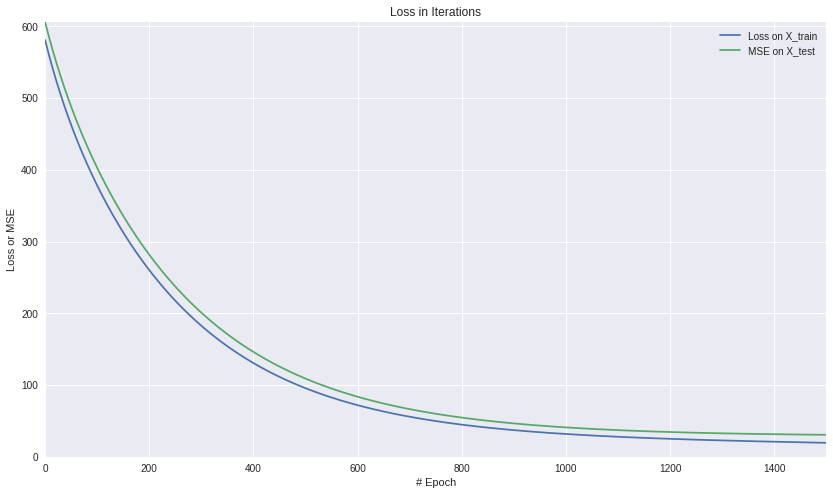

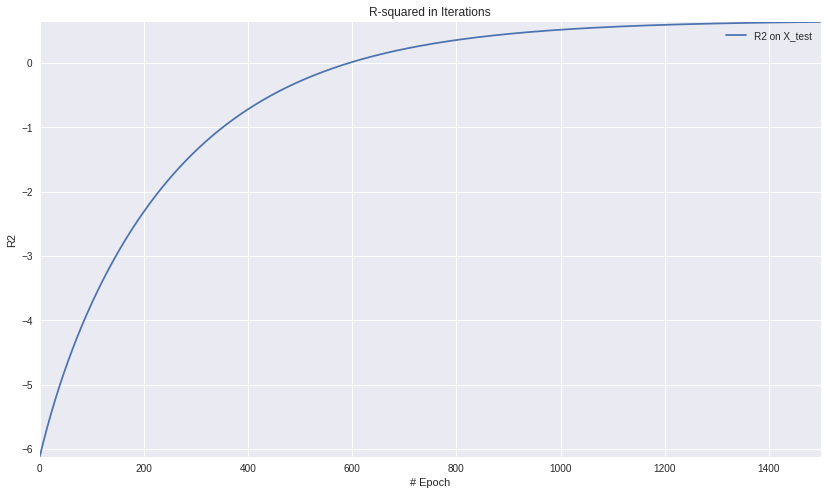

In [22]:
plt.figure(figsize=(14, 8))

plt.axis([0, num_epochs, 0, np.max([loss_epochs, mse_epochs])])
plt.plot(loss_epochs, label='Loss on X_train')
plt.plot(mse_epochs, label='MSE on X_test')
plt.title('Loss in Iterations')
plt.xlabel('# Epoch')
plt.ylabel('Loss or MSE')
plt.legend()

plt.show()

plt.figure(figsize=(14, 8))

plt.axis([0, num_epochs, np.min(rs_epochs), np.max(rs_epochs)])
plt.title('R-squared in Iterations')
plt.plot(rs_epochs, label='R2 on X_test')
plt.xlabel('# Epoch')
plt.ylabel('R2')
plt.legend()

plt.show()

## ElasticNet Regularization

In [0]:
num_outputs = y_train.shape[1]
num_inputs = X_train.shape[1]

x_tensor = tf.placeholder(dtype=tf.float32,
                          shape=[None, num_inputs], name='x')
y_tensor = tf.placeholder(dtype=tf.float32,
                          shape=[None, num_outputs], name='y')

w = tf.Variable(tf.zeros([num_inputs, num_outputs]),
                dtype=tf.float32, name='w')
b = tf.Variable(tf.zeros([num_outputs]),
                dtype=tf.float32, name='b')

model = tf.matmul(x_tensor, w) + b

ridge_param = tf.Variable(0.8, dtype=tf.float32)
ridge_loss = tf.reduce_mean(tf.square(w)) * ridge_param
lasso_param = tf.Variable(0.8, dtype=tf.float32)
lasso_loss = tf.reduce_mean(tf.abs(w)) * lasso_param

loss = tf.reduce_mean(tf.square(model - y_tensor)) + \
    ridge_loss + lasso_loss

learning_rate = 0.001
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

# mse and R2 functions
mse = tf.reduce_mean(tf.square(model - y_tensor))
y_mean = tf.reduce_mean(y_tensor)
total_error = tf.reduce_sum(tf.square(y_tensor - y_mean))
unexplained_error = tf.reduce_sum(tf.square(y_tensor - model))
rs = 1 - tf.div(unexplained_error, total_error)

In [24]:
num_epochs = 1500
loss_epochs = np.empty(shape=[num_epochs], dtype=np.float32)
mse_epochs = np.empty(shape=[num_epochs], dtype=np.float32)
rs_epochs = np.empty(shape=[num_epochs], dtype=np.float32)

mse_score = 0.0
rs_score = 0.0

with tf.Session() as tfs:
    tfs.run(tf.global_variables_initializer())
    for epoch in range(num_epochs):
        feed_dict = {x_tensor: X_train, y_tensor: y_train}
        loss_val, _ = tfs.run([loss, optimizer], feed_dict=feed_dict)
        loss_epochs[epoch] = loss_val

        feed_dict = {x_tensor: X_test, y_tensor: y_test}
        mse_score, rs_score = tfs.run([mse, rs], feed_dict=feed_dict)
        mse_epochs[epoch] = mse_score
        rs_epochs[epoch] = rs_score

print('For test data : MSE = {0:.8f}, R2 = {1:.8f} '.format(
    mse_score, rs_score))

For test data : MSE = 30.65102768, R2 = 0.63977146 


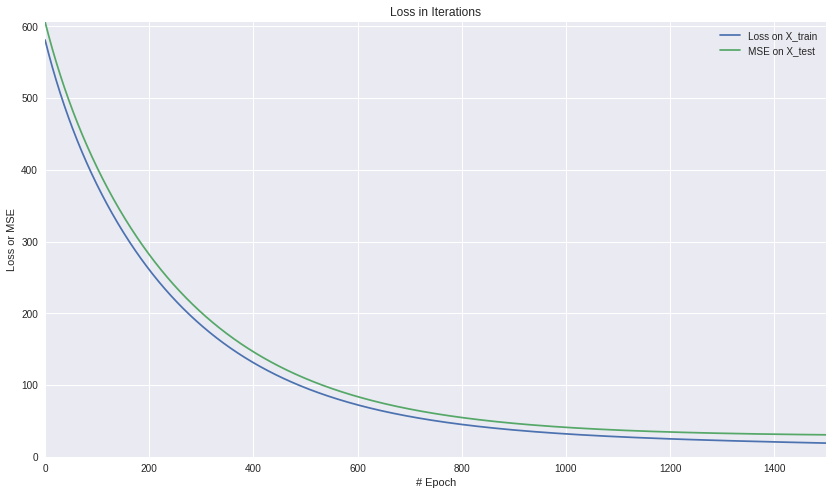

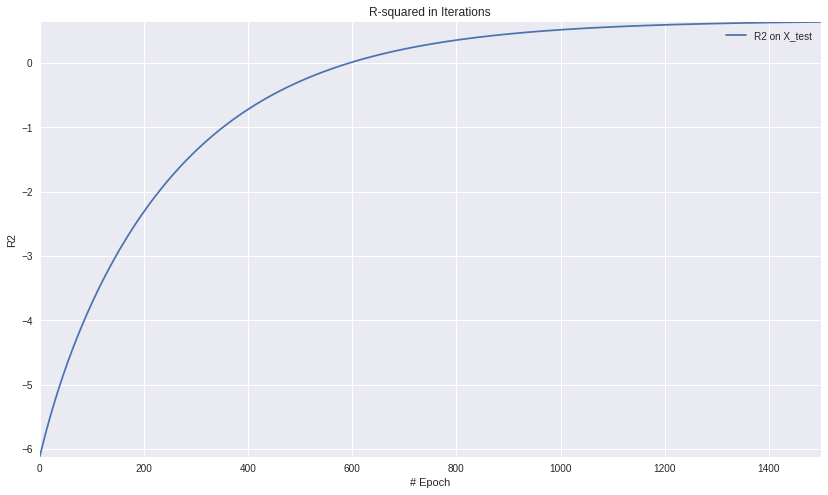

In [25]:
plt.figure(figsize=(14, 8))

plt.axis([0, num_epochs, 0, np.max([loss_epochs, mse_epochs])])
plt.plot(loss_epochs, label='Loss on X_train')
plt.plot(mse_epochs, label='MSE on X_test')
plt.title('Loss in Iterations')
plt.xlabel('# Epoch')
plt.ylabel('Loss or MSE')
plt.legend()

plt.show()

plt.figure(figsize=(14, 8))

plt.axis([0, num_epochs, np.min(rs_epochs), np.max(rs_epochs)])
plt.title('R-squared in Iterations')
plt.plot(rs_epochs, label='R2 on X_test')
plt.xlabel('# Epoch')
plt.ylabel('R2')
plt.legend()

plt.show()